In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Load datasets
train_df = pd.read_csv('/content/gdrive/MyDrive/train.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/test.csv')

In [4]:
# Display the first few rows of the training dataset
print(train_df.head())

   id class  cap-diameter cap-shape cap-surface cap-color  \
0   0     e          8.80         f           s         u   
1   1     p          4.51         x           h         o   
2   2     e          6.94         f           s         b   
3   3     e          3.88         f           y         g   
4   4     e          5.85         x           l         w   

  does-bruise-or-bleed gill-attachment gill-spacing gill-color  ...  \
0                    f               a            c          w  ...   
1                    f               a            c          n  ...   
2                    f               x            c          w  ...   
3                    f               s          NaN          g  ...   
4                    f               d          NaN          w  ...   

   stem-root  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0        NaN           NaN          w       NaN        NaN        f         f   
1        NaN             y          o       

In [5]:
# Check for missing values
missing_values = train_df.isnull().sum()
print(missing_values)

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64


In [6]:
# Drop columns with more than 50% missing data
columns_to_drop = ['cap-surface', 'gill-attachment', 'gill-spacing', 'stem-root',
                   'stem-surface', 'veil-type', 'veil-color', 'spore-print-color']
train_df = train_df.drop(columns=columns_to_drop, errors='ignore')

In [7]:
# Impute missing values
train_df['ring-type'] = train_df['ring-type'].fillna(train_df['ring-type'].mode()[0])
columns_to_impute = ['cap-diameter', 'cap-shape', 'cap-color', 'does-bruise-or-bleed',
                     'gill-color', 'stem-color', 'has-ring', 'habitat']

In [8]:
# Impute missing values
train_df['ring-type'] = train_df['ring-type'].fillna(train_df['ring-type'].mode()[0])
columns_to_impute = ['cap-diameter', 'cap-shape', 'cap-color', 'does-bruise-or-bleed',
                     'gill-color', 'stem-color', 'has-ring', 'habitat']

for column in columns_to_impute:
    if column in train_df.columns:
        if train_df[column].dtype == 'object':
            train_df[column] = train_df[column].fillna(train_df[column].mode()[0])
        else:
            train_df[column] = train_df[column].fillna(train_df[column].median())

In [9]:
# Verify that there are no more missing values
print(train_df.isnull().sum())

id                      0
class                   0
cap-diameter            0
cap-shape               0
cap-color               0
does-bruise-or-bleed    0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64


In [10]:
# Display dataset shapes and data types
print(train_df.shape)
print(test_df.shape)
print(train_df.dtypes)
print(test_df.dtypes)

(3116945, 14)
(2077964, 21)
id                        int64
class                    object
cap-diameter            float64
cap-shape                object
cap-color                object
does-bruise-or-bleed     object
gill-color               object
stem-height             float64
stem-width              float64
stem-color               object
has-ring                 object
ring-type                object
habitat                  object
season                   object
dtype: object
id                        int64
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               objec

In [11]:
# Check the value counts for the 'class' column
class_counts = train_df['class'].value_counts()
print("Value counts for 'class' column:")
print(class_counts)

Value counts for 'class' column:
class
p    1705396
e    1411549
Name: count, dtype: int64


<ipython-input-12-6fab580a0f46>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


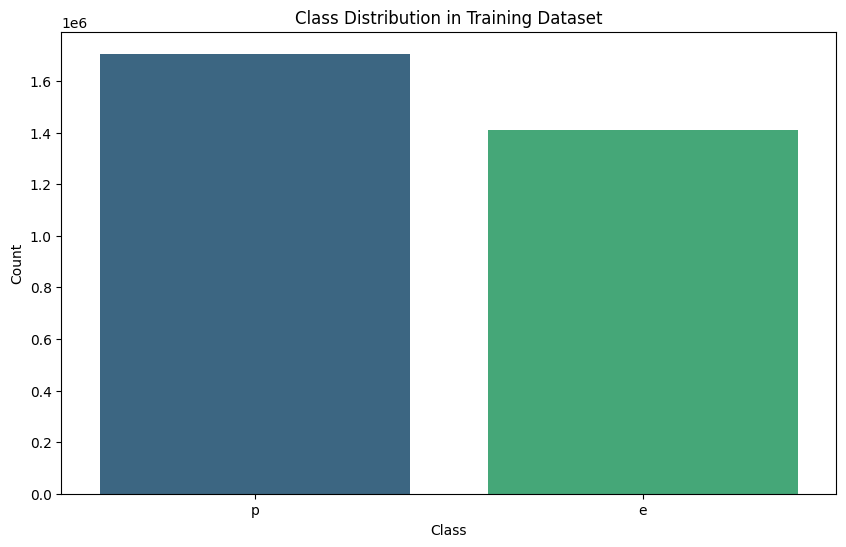

In [12]:
# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [13]:
# Summary statistics for training and testing datasets
print(train_df.describe())
print(test_df.describe())

                 id  cap-diameter   stem-height    stem-width
count  3.116945e+06  3.116945e+06  3.116945e+06  3.116945e+06
mean   1.558472e+06  6.309848e+00  6.348333e+00  1.115379e+01
std    8.997847e+05  4.657928e+00  2.699755e+00  8.095477e+00
min    0.000000e+00  3.000000e-02  0.000000e+00  0.000000e+00
25%    7.792360e+05  3.320000e+00  4.670000e+00  4.970000e+00
50%    1.558472e+06  5.750000e+00  5.880000e+00  9.650000e+00
75%    2.337708e+06  8.240000e+00  7.410000e+00  1.563000e+01
max    3.116944e+06  8.067000e+01  8.872000e+01  1.029000e+02
                 id  cap-diameter   stem-height    stem-width
count  2.077964e+06  2.077957e+06  2.077963e+06  2.077964e+06
mean   4.155926e+06  6.306192e+00  6.346509e+00  1.114837e+01
std    5.998567e+05  4.685462e+00  2.698978e+00  8.100181e+00
min    3.116945e+06  0.000000e+00  0.000000e+00  0.000000e+00
25%    3.636436e+06  3.310000e+00  4.670000e+00  4.970000e+00
50%    4.155926e+06  5.740000e+00  5.880000e+00  9.640000e+00
75%    4

**Exploratory Data Analysis**

*Distribution of Numerical Features*

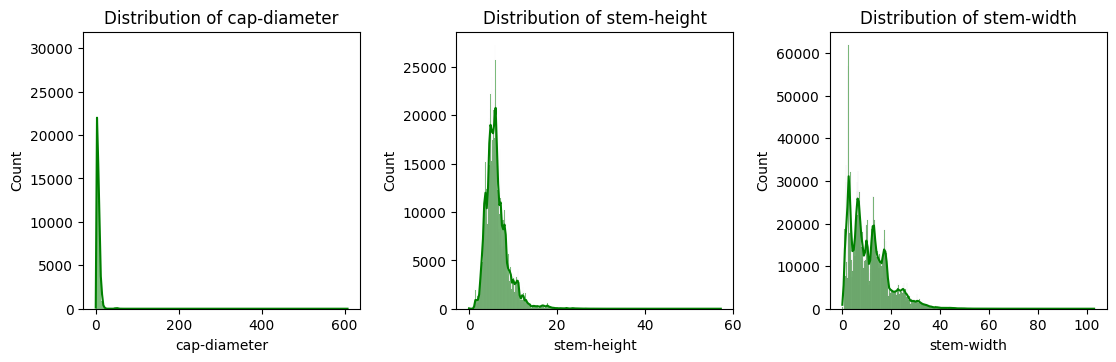

In [14]:
# Plot histograms for numerical features in the test dataset
plt.figure(figsize=(15, 10))

# Select numerical columns, excluding the 'id' column
numeric_columns = test_df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = [col for col in numeric_columns if col != 'id']

# Plot histograms for each numerical column
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(test_df[column], kde=True, color='green')
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

*Distribution of Categorical Features*

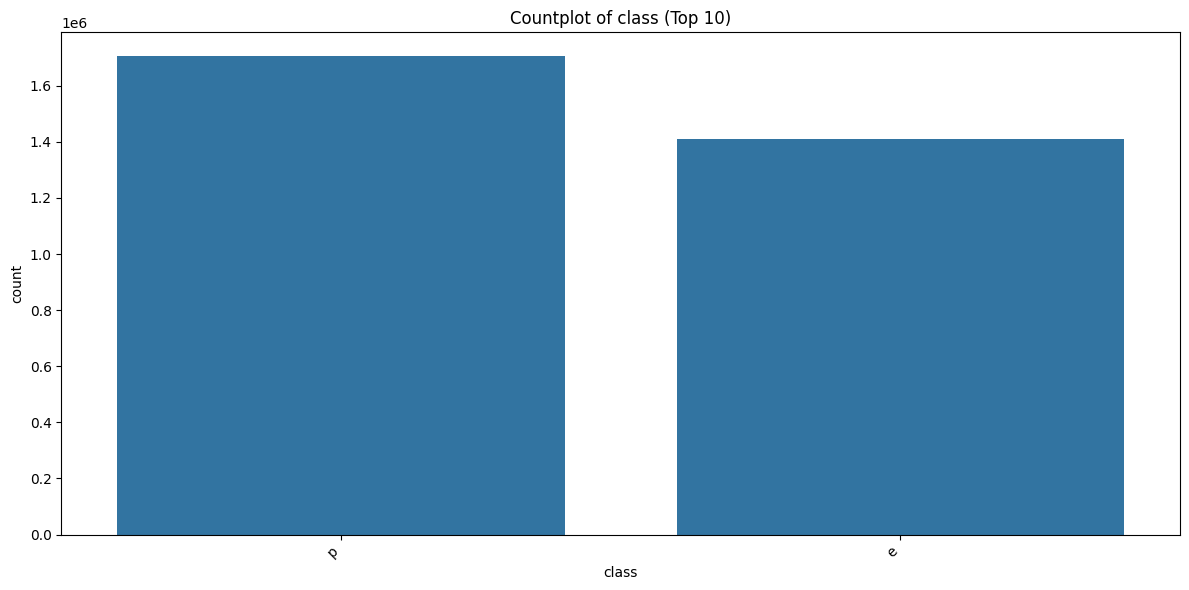

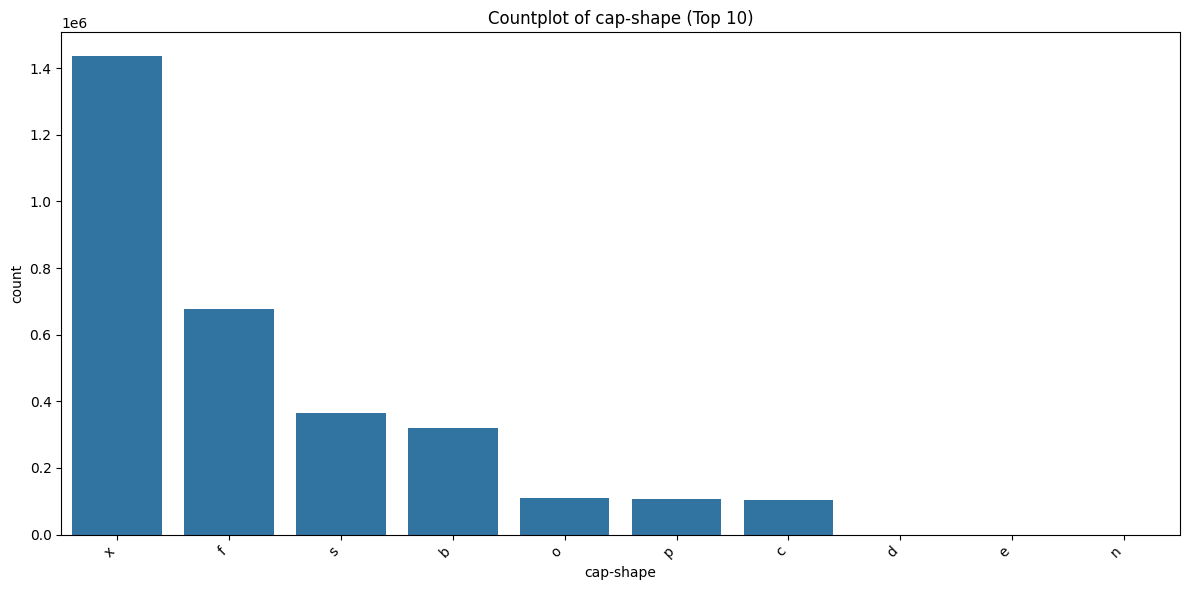

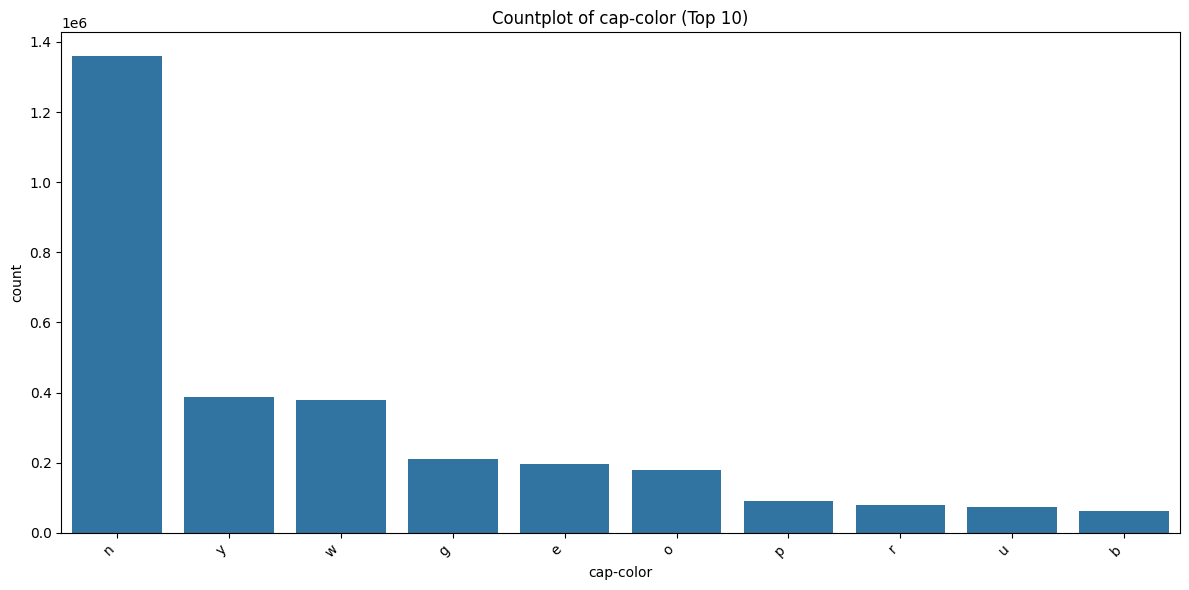

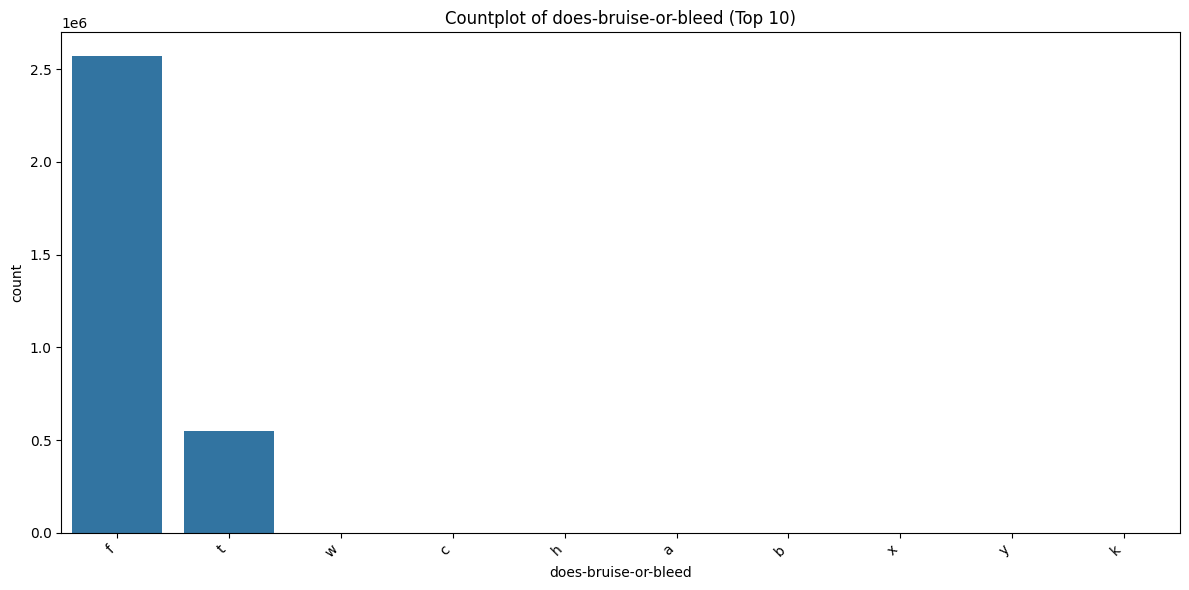

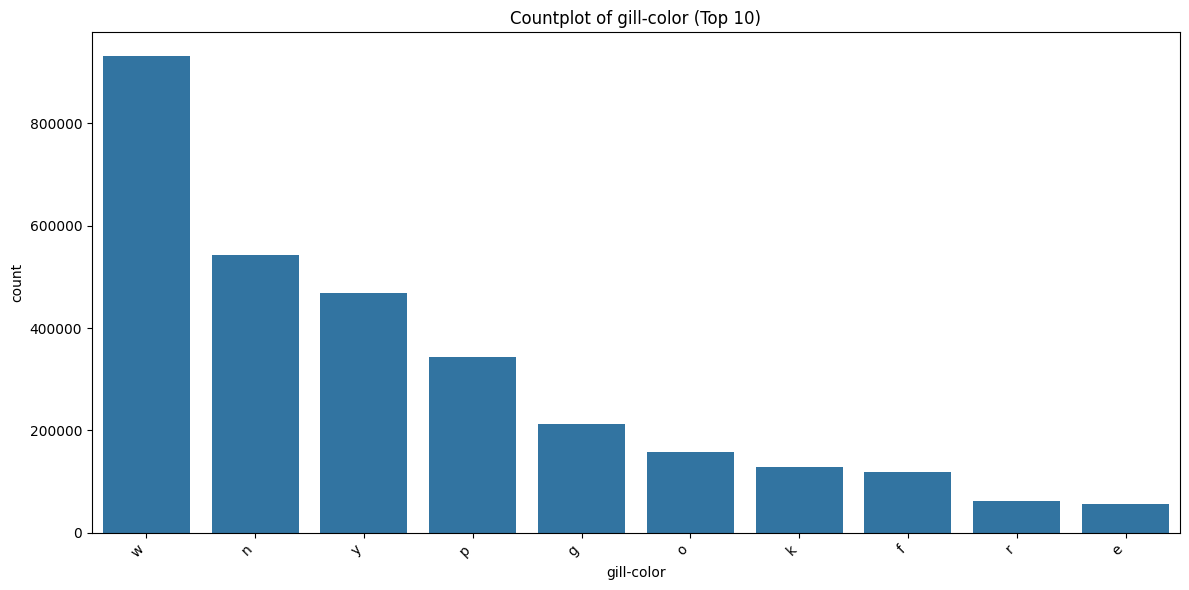

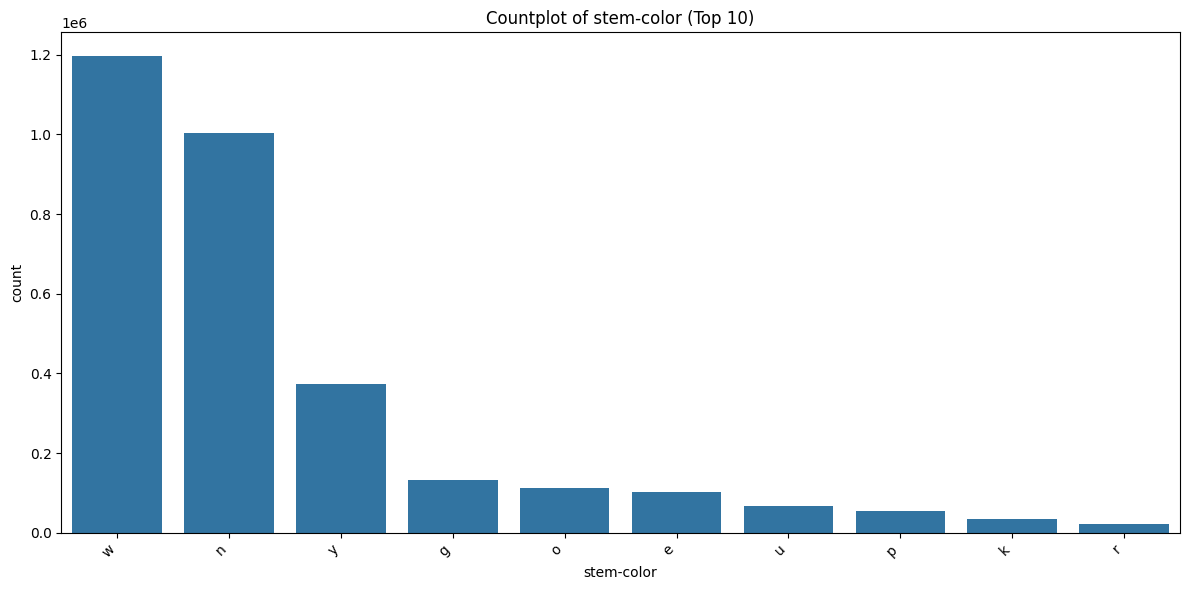

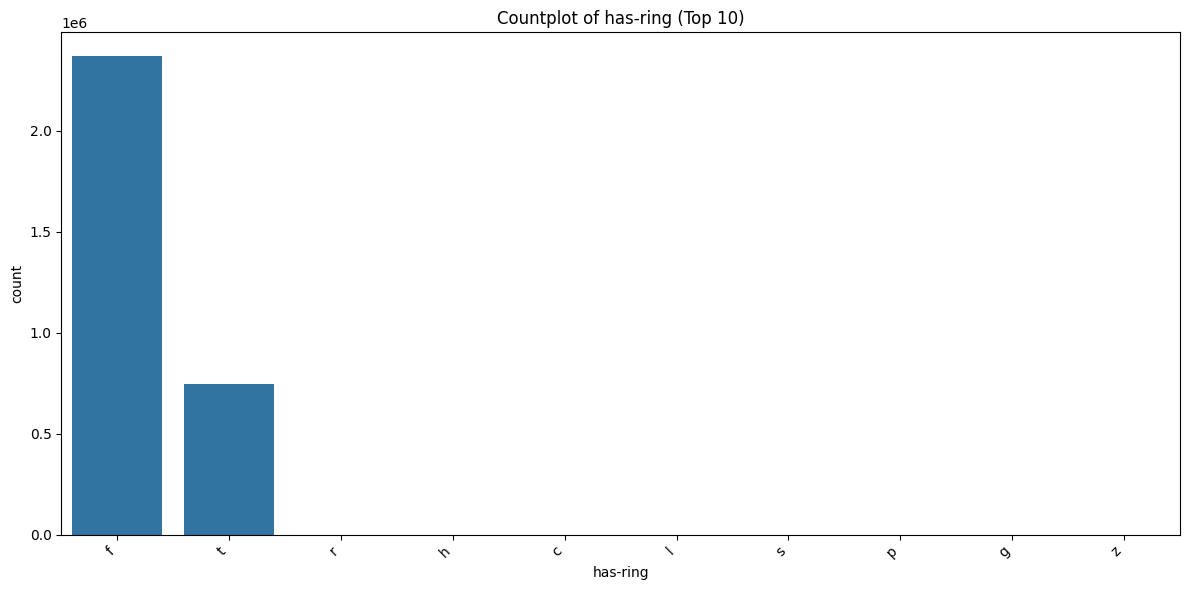

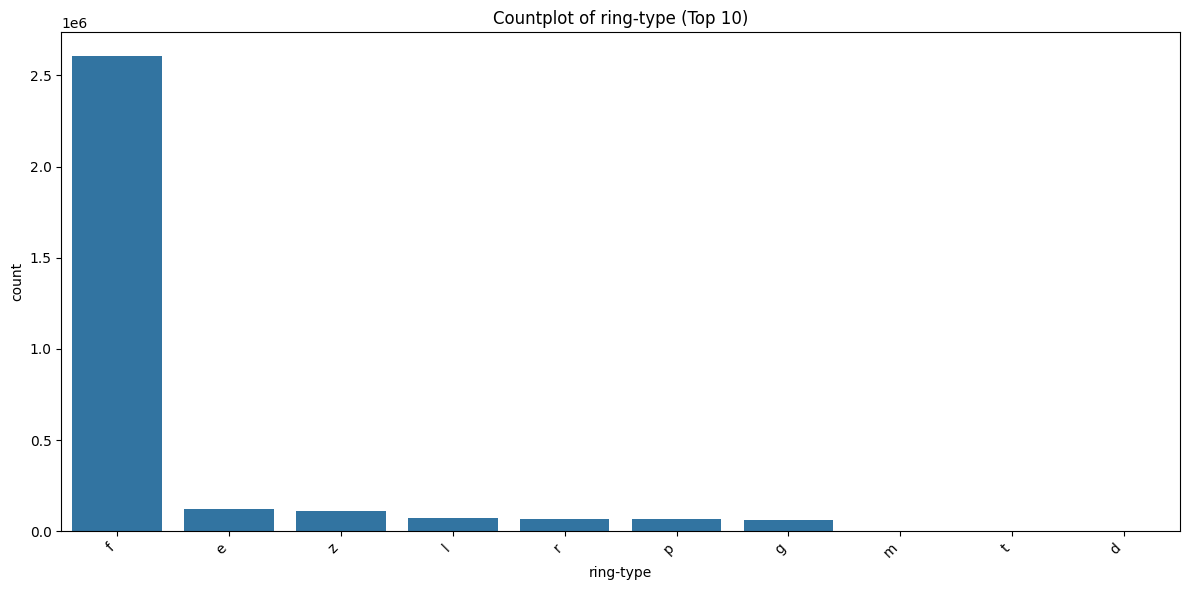

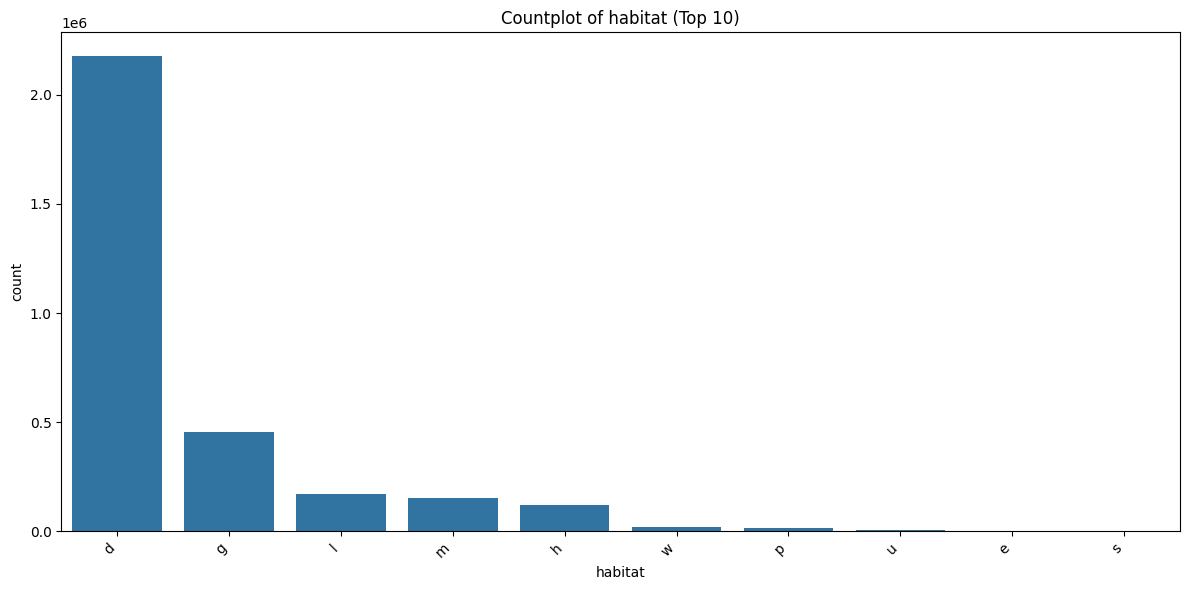

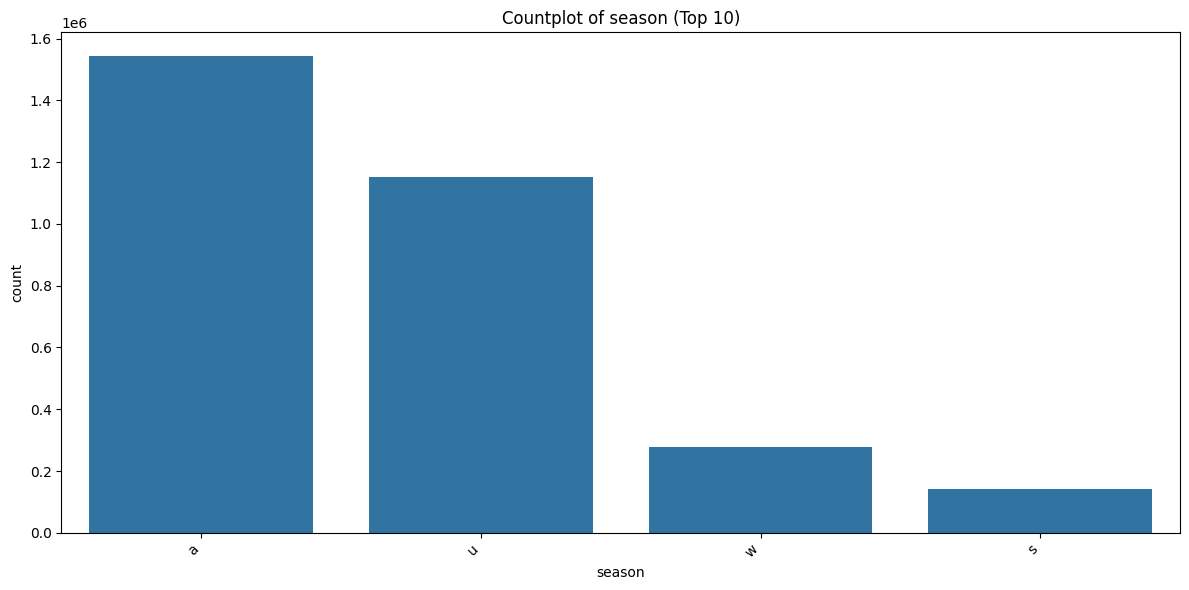

In [15]:
# Plot countplots for each categorical column, excluding 'Unknown' values
categorical_columns = train_df.select_dtypes(include=['object']).columns  # List of categorical columns

for column in categorical_columns:
    # Exclude 'Unknown' values
    filtered_data = train_df.loc[train_df[column] != 'Unknown']

    # Get the top 10 most frequent categories
    top_categories = filtered_data[column].value_counts().nlargest(10).index
    filtered_data = filtered_data[filtered_data[column].isin(top_categories)]

    plt.figure(figsize=(12, 6))  # Increase figure size
    sns.countplot(data=filtered_data, x=column, order=top_categories)
    plt.title(f'Countplot of {column} (Top 10)')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
    plt.tight_layout()
    plt.show()

*Correlation between Numerical Features*

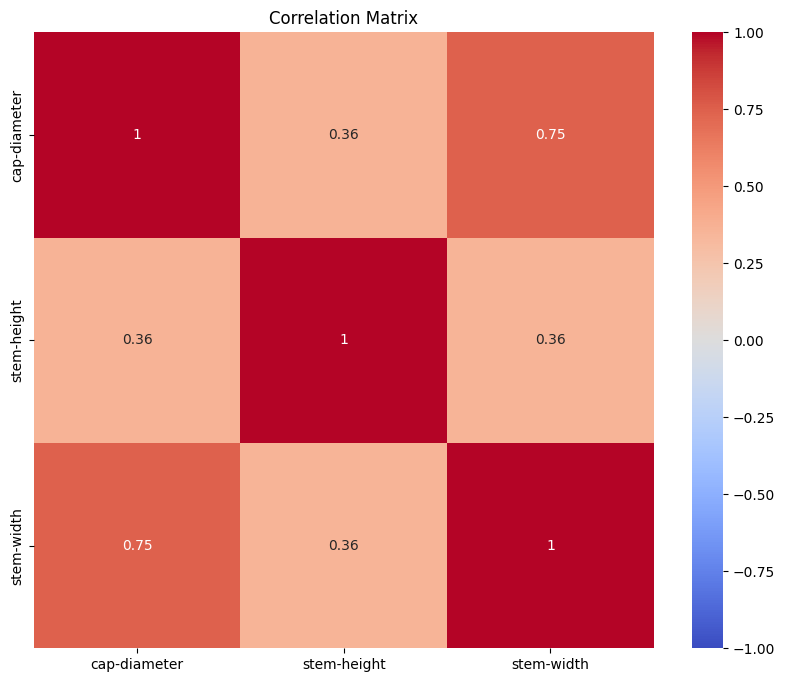

In [16]:
# Select numeric columns excluding 'id'
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col != 'id']

# Compute the correlation matrix
correlation_matrix = train_df[numeric_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

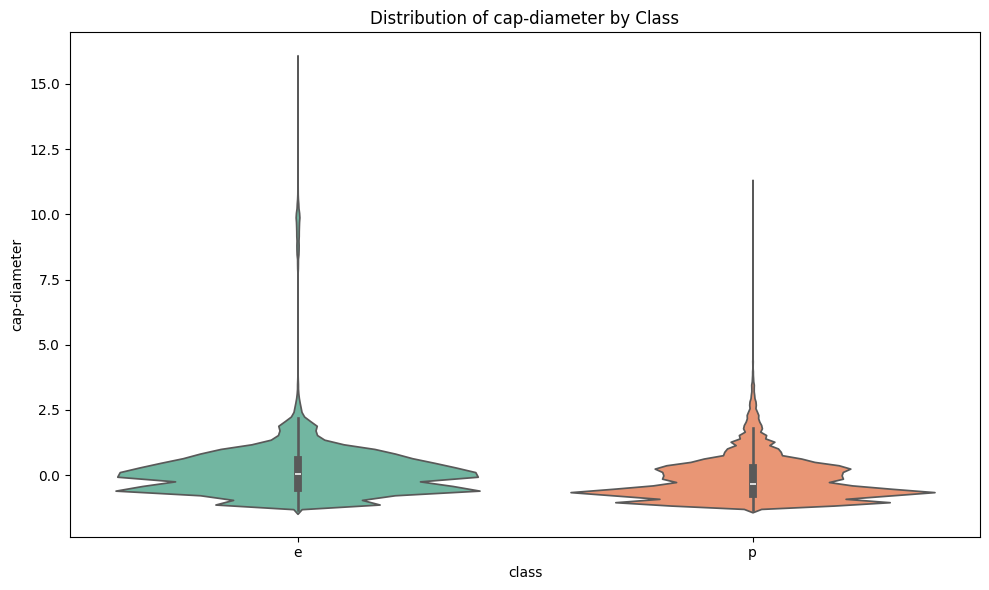

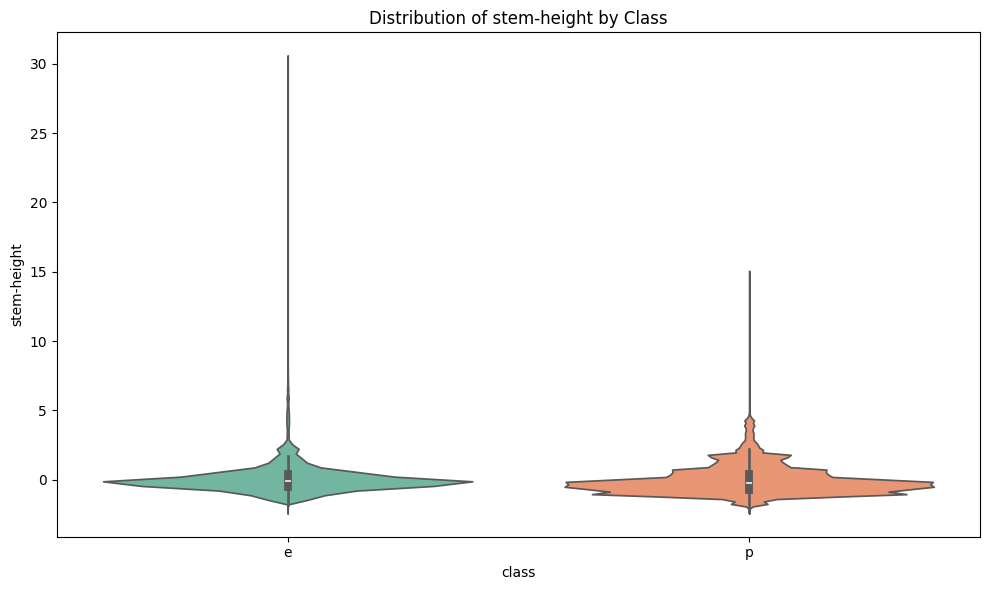

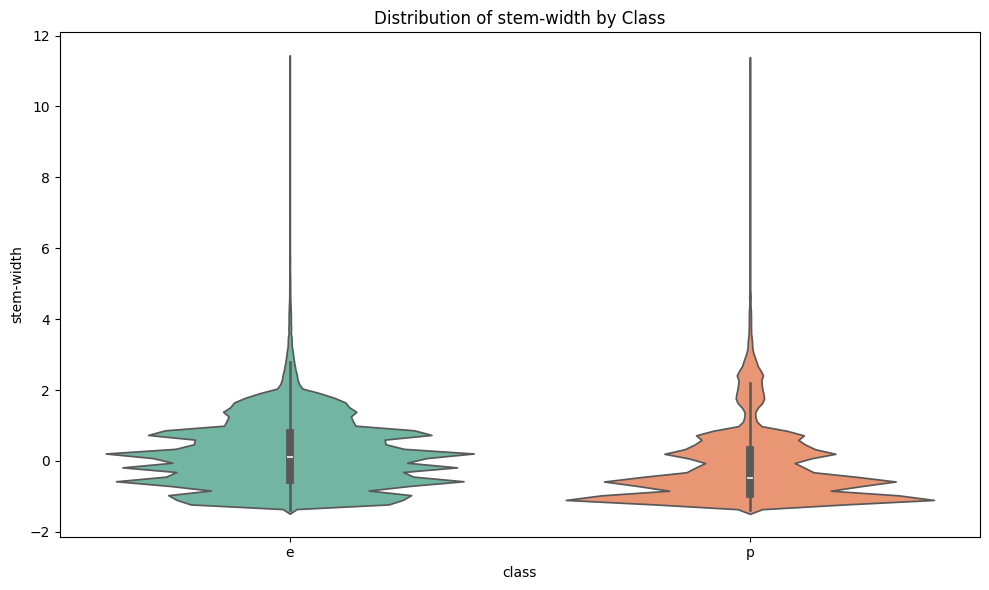

In [17]:
from sklearn.preprocessing import StandardScaler

# Exclude 'id' column from numerical columns
numerical_columns = train_df.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in numerical_columns if col != 'id']

# Scale the numerical columns for better visualization
scaler = StandardScaler()
train_df_scaled = train_df.copy()
train_df_scaled[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])

# Plot violin plots for each scaled numerical column, using 'class' as hue
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=train_df_scaled, x='class', y=column, hue='class', palette='Set2', legend=False)
    plt.title(f'Distribution of {column} by Class')
    plt.tight_layout()
    plt.show()

*Correlations between Categorical Features*

In [18]:
from scipy.stats import chi2_contingency

# List of categorical columns
categorical_columns = train_df.select_dtypes(include=['object']).columns

# Exclude 'id' and 'class' if they are in the list
categorical_columns = [col for col in categorical_columns if col not in ['id', 'class']]

for column in categorical_columns:
    if column != 'id':  # Exclude 'id' if it is in the list
        cross_tab = pd.crosstab(train_df[column], train_df['class'])
        chi2, p, _, _ = chi2_contingency(cross_tab)
        print(f'Chi-Square Test for {column}: chi2 = {chi2:.2f}, p-value = {p:.3f}')

Chi-Square Test for cap-shape: chi2 = 87532.21, p-value = 0.000
Chi-Square Test for cap-color: chi2 = 208411.84, p-value = 0.000
Chi-Square Test for does-bruise-or-bleed: chi2 = 4432.37, p-value = 0.000
Chi-Square Test for gill-color: chi2 = 150918.77, p-value = 0.000
Chi-Square Test for stem-color: chi2 = 206410.84, p-value = 0.000
Chi-Square Test for has-ring: chi2 = 7715.95, p-value = 0.000
Chi-Square Test for ring-type: chi2 = 116598.96, p-value = 0.000
Chi-Square Test for habitat: chi2 = 98422.30, p-value = 0.000
Chi-Square Test for season: chi2 = 69393.17, p-value = 0.000


In [19]:
# Encoding categorical variables for the training dataset
label_encoders = {}
for column in train_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    train_df[column] = le.fit_transform(train_df[column])
    label_encoders[column] = le

# Apply the same label encoders to the test dataset with handling for unseen categories
for column, le in label_encoders.items():
    if column in test_df.columns:
        try:
            test_df[column] = le.transform(test_df[column])
        except ValueError:
            # Handling unseen categories
            unseen_labels = set(test_df[column].unique()) - set(le.classes_)
            for unseen_label in unseen_labels:
                le.classes_ = np.append(le.classes_, unseen_label)
            test_df[column] = le.transform(test_df[column])


In [20]:
# Split the data into features (X) and target (y) for the training set only
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']

In [21]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [22]:
# Train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [23]:
# Predict and evaluate the Decision Tree model
y_val_pred_dt = dt_model.predict(X_val)
dt_accuracy = accuracy_score(y_val, y_val_pred_dt)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")
print("Classification Report for Decision Tree:\n", classification_report(y_val, y_val_pred_dt))
print("Confusion Matrix for Decision Tree:\n", confusion_matrix(y_val, y_val_pred_dt))

Decision Tree Accuracy: 0.97
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97    282397
           1       0.97      0.97      0.97    340992

    accuracy                           0.97    623389
   macro avg       0.97      0.97      0.97    623389
weighted avg       0.97      0.97      0.97    623389

Confusion Matrix for Decision Tree:
 [[272519   9878]
 [  9765 331227]]


In [ ]:
# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict and evaluate the Random Forest model
y_val_pred_rf = rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print("Classification Report for Random Forest:\n", classification_report(y_val, y_val_pred_rf))
print("Confusion Matrix for Random Forest:\n", confusion_matrix(y_val, y_val_pred_rf))

Random Forest Accuracy: 0.98
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    282397
           1       0.99      0.98      0.98    340992

    accuracy                           0.98    623389
   macro avg       0.98      0.98      0.98    623389
weighted avg       0.98      0.98      0.98    623389

Confusion Matrix for Random Forest:
 [[277376   5021]
 [  5717 335275]]


In [25]:
# Save the models and label encoders as pickle files
save_dir = '/content/gdrive/MyDrive/Colab Notebooks/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with open(os.path.join(save_dir, 'decision_tree_model.pkl'), 'wb') as file:
    pickle.dump(dt_model, file)

#with open(os.path.join(save_dir, 'random_forest_model.pkl'), 'wb') as file:
    #pickle.dump(rf_model, file)

with open(os.path.join(save_dir, 'label_encoders.pkl'), 'wb') as file:
    pickle.dump(label_encoders, file)

print("Models and label encoders have been saved as pickle files.")

Models and label encoders have been saved as pickle files.
